In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


<h2> Table of Content </h2>
<ul> <li> <a href="#preperation"> Preparation </a> </li>
    <li> <a href="#importdata"> Load the datas </a> </li>
    <li> <a href="#look"> First Look at the data</a> </li>
    <li> <a href="#exploration"> Datas explorations</a></li>
    <li> <a href="#Modeling"> Modeling </a> </li>
    </ul>
<hr>

<h2 id="preparation">Preparation</h2>

In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt 
import os
import plotly_express as px
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import TweetTokenizer , word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , GRU,Input,TimeDistributed , Embedding,Bidirectional,\
BatchNormalization,Dropout,LSTM ,GlobalAveragePooling1D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy ,categorical_crossentropy
from nltk.stem import PorterStemmer
from collections import Counter
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score ,KFold
import numpy as np 
from sklearn.metrics import roc_auc_score, accuracy_score ,auc , roc_curve

<h2 id=importdata>Load the datas</h2>

In [3]:
root="/kaggle/input/nlp-getting-started/"
train_df=pd.read_csv(os.path.join(root,"train.csv"))
test_df=pd.read_csv(os.path.join(root,"test.csv"))
df_sub=pd.read_csv(os.path.join(root,"sample_submission.csv"))

<h2 id="#look">First Look at the data

In [4]:
# Take a look at the datas 
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# info about training datas
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
# info about test datas
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


<h2 id="

==> It obviously, that we should handle the missing values of the variables location and keyword.

In [7]:
#Some statistics on the datas.
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


<h2 id="#exploration"> Datas explorations </h2>

<h3> Let's Ckeck Target Didtribution</h3>

#### Check For Datas Imbalance

In [8]:
fig=px.pie(train_df,names="target",title="Target Disributions")
fig.update_layout(title={"x":0.475,"y":0.9,"xanchor":"center","yanchor":"top"})
fig.show()

<h3> Tweets Location </h3>

In [9]:
nb=len(train_df['location'].unique())
print("Tweets come from {} differents locations ".format(nb))

Tweets come from 3342 differents locations 


<h3> Top 20 Locations </h3>

In [10]:
top_20=pd.DataFrame(train_df['location'].value_counts()[:20]).reset_index(drop=False)
top_20.rename(columns={'index':"Locations","location":"Occurences"},inplace=True)

In [11]:
fig=px.bar(top_20,x="Locations",y="Occurences",orientation='v',color="Occurences",title=\
          "Top 20 most used Countries ")
fig.update_layout(title={"x":0.475,"y":0.9,"xanchor":"center","yanchor":"top"})
fig.show()

In [12]:
df=train_df[train_df['location'].notna()]

In [13]:
lb=LabelEncoder()
df['location']=lb.fit_transform(df['location'])

In [14]:
X=df['location']
Y=df['target']

#T_sne implementation

X_reduced=TSNE(n_components=2,random_state=42).fit_transform(X.values.reshape(-1,1))

Text(0.5, 1.0, 't-SNE')

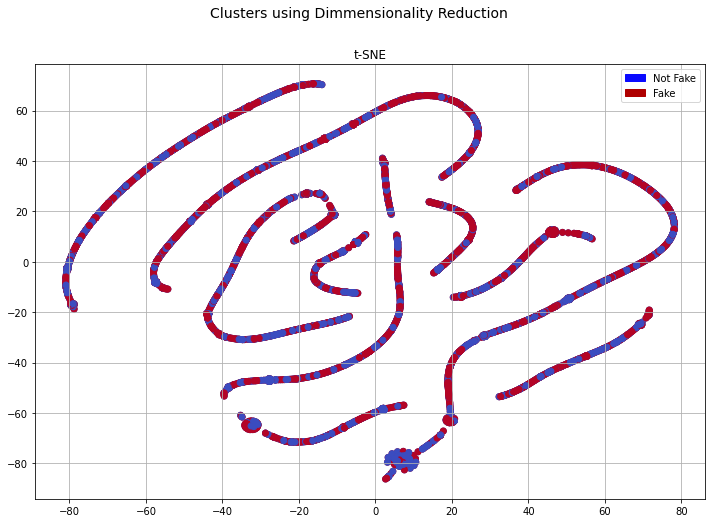

In [15]:
f,ax=plt.subplots(1,1,figsize=(12,8))
blue_patch = mpatches.Patch(color='#0A0AFF' ,label='Not Fake')
red_patch = mpatches.Patch(color='#AF0000' ,label='Fake')

plt.scatter(X_reduced[:,0],X_reduced[:,1],c=(Y==1),label=["Not Fake"],cmap="coolwarm"\
            )
plt.scatter(X_reduced[:,0],X_reduced[:,1],c=(Y==0),label=["Fake"],cmap="coolwarm"\
           )
plt.grid(True)
plt.legend(handles=[blue_patch,red_patch])
f.suptitle('Clusters using Dimmensionality Reduction',fontsize=14)
plt.title("t-SNE")

<h2 id=

<font color=redblue> <b>the above t-SNE clustering shows that fake and real tweets can come from any locations. So the location can not be an important features to classify the tweets. </font>

<h3> KeyWords </h3>

#### Top 20 KeyWords

In [16]:
# most used word for disaster tweet
df=train_df[train_df['target']==1]
top_20=pd.DataFrame(df['keyword'].value_counts()[:20]).reset_index(drop=False)
top_20.columns=['keywords','occurences']

In [17]:
fig=px.bar(top_20,x="keywords",y="occurences",color='occurences',title=\
          "Top 20 most used keyword for disaster tweets")
fig.update_layout(title={"x":0.475,"y":0.9,"xanchor":"center","yanchor":\
                        "top"})
fig.show()

In [18]:
df=train_df[train_df["keyword"].notna()]

In [19]:
le=LabelEncoder()
df['keyword']=le.fit_transform(df['keyword'])

In [20]:
X=df['keyword']
Y=df['target']
#T-SNE implementation
X_reduced=TSNE(n_components=2,random_state=41).fit_transform(\
                                                             X.values.reshape(-1,1))

Text(0.5, 1.0, 'T-SNE')

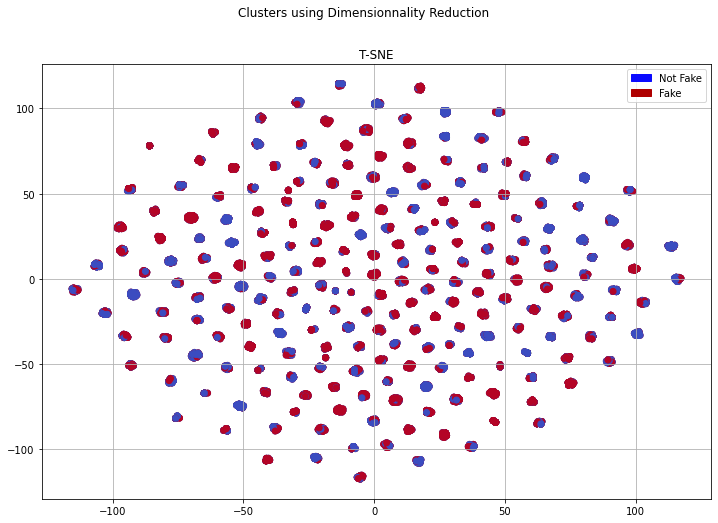

In [21]:
f,ax=plt.subplots(1,1,figsize=(12,8))
blue_patch=mpatches.Patch(color='#0A0AFF',label='Not Fake')
red_patch=mpatches.Patch(color='#AF0000',label='Fake')

f.suptitle("Clusters using Dimensionnality Reduction ")

ax.scatter(X_reduced[:,0],X_reduced[:,1],c=(Y==1),label="Not Fake",\
          cmap="coolwarm")
ax.scatter(X_reduced[:,0],X_reduced[:,1],c=(Y==0),label="Kake",\
          cmap="coolwarm")
ax.grid(True)
ax.legend(handles=[blue_patch,red_patch])
plt.title("T-SNE")

<font color=redblue> The T-SNE clustering above, shows a distingushed clusters for real disaster tweets and fake disaster tweets, which confirm that there is distingushed keywords for each of these cluster.

<h3> text analysis </h3>

In [22]:
tx=" ".join(df['text'].values.tolist())

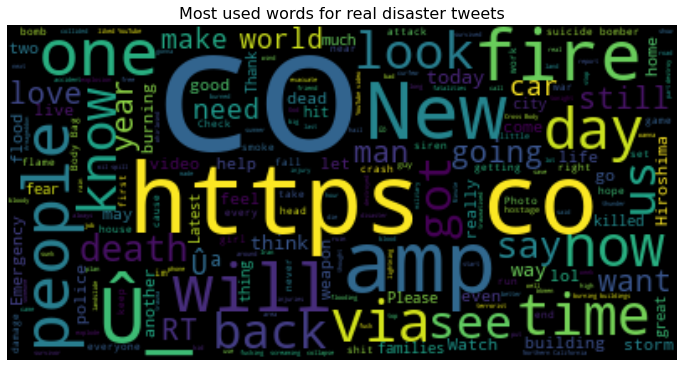

In [23]:
fig,ax1=plt.subplots(1,1,figsize=(12,16))
wordcl=WordCloud().generate(tx)
plt.imshow(wordcl,interpolation="bilinear")
plt.axis("off")
plt.title("Most used words for real disaster tweets",fontsize=16)
plt.show()

<h3> Text Modeling Topic </h3>

In [24]:
tx=train_df['text'].values.tolist()

In [25]:
count_vectoriser=CountVectorizer(stop_words="english",max_df=0.95,min_df=2)
tf=count_vectoriser.fit_transform(tx)

In [26]:
#GridSearch to choice the number of topics to extract
params={'n_components':[5,10,20,50]}
lda=LatentDirichletAllocation()
model=GridSearchCV(lda,params)
model.fit(tf)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [5, 10, 20, 50]})

In [27]:
print("Best Model's Params :{}".format(model.best_params_))

Best Model's Params :{'n_components': 5}


In [28]:
model=model.best_estimator_

In [29]:
nb_topics=5
def display_topic(md,nb_topics,features,no_words):
    for topic_idx ,topic in enumerate(md.components_):
        print("Topic {} :".format(topic_idx))
        print(" ".join(features[j] for j in topic.argsort()[-no_words-1:-1]))
        

In [30]:
# Display the most 5 represented topic in our corpus
features=count_vectoriser.get_feature_names()
no_words=10
display_topic(model,nb_topics,features,no_words)

Topic 0 :
love amp new video youtube like don https body just
Topic 1 :
families crash wildfire california new https police news emergency û_
Topic 2 :
let just typhoon obama https fires don disaster amp like
Topic 3 :
people today hot û_ best collapse mass gt like hiroshima
Topic 4 :
news watch pm bomber school mh370 https amp suicide just


<h2 id="Modeling"> Modeling </h2>

<h3> Naives Bayes: Baseline</h3>

In [31]:
def tokenizer(x):
    token = TweetTokenizer().tokenize(x)
    return token
def stem(x):
    stemmer = PorterStemmer()
    res = [stemmer.stem(elt) for elt in x]
    return res 

In [32]:
# Compute the frequency apparition of each word in our corpus
stop_words = Counter([x for row in train_df['text'].values for x in row.split(" ")])

In [33]:
# We consider the 100 most used words as common words.
common_words = list(zip(*stop_words.most_common(100)))[0]

In [34]:
common_words = set(common_words)

In [35]:
common_words.update(nltk.corpus.stopwords.words("english"))

In [36]:
training=train_df['text'].values.tolist()
test=test_df['text'].values.tolist()

In [37]:
countvectorizer=TfidfVectorizer(tokenizer=tokenizer,\
                               max_df=0.95,min_df=2)

In [38]:
X_tr=countvectorizer.fit_transform(training)
X_pr=countvectorizer.fit_transform(test)

In [39]:
Y_tr=train_df["target"].values

In [40]:
xtr,xts,ytr,yts=train_test_split(X_tr,Y_tr,test_size=0.2,stratify=Y_tr)

In [41]:
#class_weights=class_weight.compute_class_weight("balanced",\
                                                #np.unique(Y_tr),Y_tr)

In [42]:
estimator=MultinomialNB()
estimator.fit(xtr,ytr)

MultinomialNB()

In [43]:
# estimate performance accuracy
sc=estimator.score(xts,yts)
print("The score accuracy of the Naive bayes estimator is : {}".\
      format(sc))

The score accuracy of the Naive bayes estimator is : 0.7715036112934996


<h3> Naives Bayes: fine tunnned

In [44]:
def preprocessing(x):
    """
    - Lowercase the sentence. 
    - Change 't to 'not'.
    - Remove @name
    - Remove all stop words unless 'can' and 'not'.
    - Remove all punctuation and special charecter except '!'
    - Remove trailing white space.
    """
    x = x.lower()
    x = re.sub(r"(@.?)[\s]"," ",x)
    x = re.sub(r"\'t","not",x)
    x= " ".join([word for word in x.split(" ") if word not in common_words or word in ("can","not")])
    x= re.sub(r"([\?\\\,\:\;\.\'\"\(\)])"," ",x)
    x= re.sub(r"\s+"," ",x).strip()
    return x
    

In [45]:
# Apply our preprocessing treatment to our training datas.
training = [preprocessing(text) for text in train_df['text'].values]

In [46]:
# Define TF_IDF trasnformer with the new subtility to take en consideration ngram from 1 to 3.
tf_idf = TfidfVectorizer(max_df=0.95,min_df=2)

In [47]:
X = tf_idf.fit_transform(train_df['text'].values)

In [48]:
xtr,xts,ytr,yts = train_test_split(X,Y_tr,test_size=0.2,stratify=Y_tr)

In [49]:
def get_auc_cv(model):
    kf = KFold(5,shuffle=True,)
    auc = cross_val_score(model,xtr,ytr,cv=kf,scoring="roc_auc")
    
    return auc.mean()

In [50]:
res = pd.Series([get_auc_cv(MultinomialNB(i)) for i in np.arange(1,10,0.1)],index=np.arange(1,10,0.1))

Best_alpha : 1.0


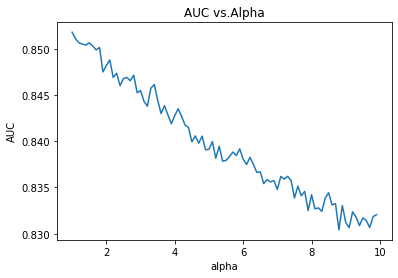

In [51]:
best_alpha = res.idxmax()
print("Best_alpha : {}".format(best_alpha))

plt.plot(res)
plt.title("AUC vs.Alpha")
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.show()

In [52]:
def evaluate_roc(probs,y_true):
    """ 
    - Print AUC and accuracy score
    - plot Roc curve.
    @params: probs(np.array):an array of predicted probabilities with shape (len(y_true,2)).
    @params: y_true : an array of the true value with shape (len(y_true),)
    """
    prob = probs[:,1]
    fpr,tpr,threshold = roc_curve(y_true,prob)
    AUC = auc(fpr,tpr)
    print("AUC:{}".format(AUC))
    
    # Get the accuracy score.
    ypred = np.where(prob>0.5,1,0)
    accuracy = accuracy_score(y_true,ypred)
    print("The accuracy score: {}".format(accuracy))
    
    # Plot the roc curve 
    plt.plot(fpr,tpr,'b',label='AUC')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc="best")
    plt.title("Receiver Operating Characteristic")
    plt.show()

In [53]:
model = MultinomialNB(alpha=best_alpha) # define Naives bayes with the best hyperparameter.
model.fit(xtr,ytr)
probs = model.predict_proba(xts)

AUC:0.8558732136133134
The accuracy score: 0.8154957321076822


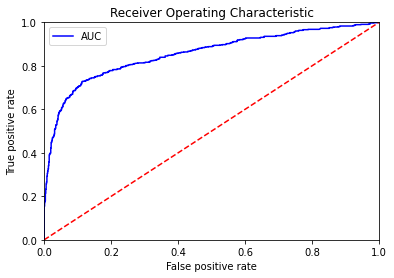

In [54]:
evaluate_roc(probs,yts)

<font color=redblue> The Gread search to select the best hyperparameter for our model , had enhanced slightly the performance of our model. We should mention that neither the processing of datas as detailed in the function named preprocessing, nor the the n_gram with range 1 to 3, had positive effect on the performance. </font> 

<h3>RNN Model </h3>

In [55]:
# Mandatory functions to prepare datas
voc_size = 20000
max_len=100
def tokenize(x):
    tk=Tokenizer(char_level=False)
    tk.fit_on_texts(x)
    return tk.texts_to_sequences(x),tk
def pad(x,max_len=None):
    if max_len is None:
        l=[len(s) for s in x]
        max_len=max(l)
    return pad_sequences(x,maxlen=max_len,padding='pre')
       
def preprocessing(x):
    seq_x,tk=tokenize(x)
    return  pad(seq_x),tk

In [56]:
# Define the model
def model(input_shape,size,emb_size):
    lr=1e-3
    md= Sequential()
    md.add(Embedding(size,emb_size,input_length=input_shape[1]))
    md.add(BatchNormalization())
    md.add(Bidirectional(GRU(50,return_sequences=True),\
                         input_shape = (emb_size,1)))
    
    md.add(BatchNormalization())
    md.add(Dropout(0.3))
    md.add(TimeDistributed(Dense(50,activation="softmax")))
    md.add(BatchNormalization())
    md.add(Dropout(0.1))
    md.add(Dense(1,activation="sigmoid"))
    md.compile(loss=sparse_categorical_crossentropy,optimizer=Adam(lr),metrics=["accuracy"])
    return md

In [57]:
#Prepare datas
inp=train_df['text'].tolist()
X,tk=preprocessing(inp)

In [58]:
#Reshape datas
X=X.reshape(-1,X.shape[1],1)
input_shape=X.shape

In [59]:
#Corpus size
size=len(tk.word_index)

In [60]:
#Build Model
model= model(input_shape,size+1,50)

In [61]:
Y=train_df["target"].values

In [62]:
model.fit(X,Y,batch_size=32,shuffle=True,validation_split=0.1,epochs=10)

Epoch 1/10
215/215 [==============================] - 5s 22ms/step - loss: 1.6035 - accuracy: 0.5427 - val_loss: 2.5076 - val_accuracy: 0.5341
Epoch 2/10
215/215 [==============================] - 4s 20ms/step - loss: 0.7246 - accuracy: 0.5653 - val_loss: 0.7790 - val_accuracy: 0.5341
Epoch 3/10
215/215 [==============================] - 4s 20ms/step - loss: 0.7023 - accuracy: 0.5654 - val_loss: 0.6995 - val_accuracy: 0.5300
Epoch 4/10
215/215 [==============================] - 4s 18ms/step - loss: 0.6973 - accuracy: 0.5654 - val_loss: 0.6960 - val_accuracy: 0.5300
Epoch 5/10
215/215 [==============================] - 4s 18ms/step - loss: 0.6988 - accuracy: 0.5654 - val_loss: 0.6948 - val_accuracy: 0.5300
Epoch 6/10
215/215 [==============================] - 4s 20ms/step - loss: 0.6957 - accuracy: 0.5653 - val_loss: 0.6944 - val_accuracy: 0.5300
Epoch 7/10
215/215 [==============================] - 4s 20ms/step - loss: 0.6949 - accuracy: 0.5653 - val_loss: 0.6940 - val_accuracy: 0.5300

<font color=redblue> The RNN model don't give better result than naivebayes. Indeed, he barely gives result near to the result of the random estimator. Therefore, The RNN model don't adapted to such binair classification. </font>

<h3> Fine-Tunning Bert

<h4> Import Required Librairies:

In [63]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=2faa8d137fc91cd8c88c77c6b8ececc422fc6947a57037d3c915da935de15450
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [64]:
from transformers import BertForSequenceClassification,BertTokenizer,AdamW,\
get_linear_schedule_with_warmup,BertModel
import torch 
from torch.utils.data import DataLoader,TensorDataset,SequentialSampler
from GPUtil import showUtilization as gpu_usage
from numba import cuda


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [65]:
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

<h4>Tokenization and Input Formatting:

> Hereunder, we will perform some slight preprocessing on our text removing entity mentions and special character. The level of processing here is much less than in previous approach because BERT was trained with the entire sentence.

In [66]:
def preprocessing(text):
    """ 
    - Remove entity mention @
    - Remove some special characters (exple: #)
    - Replace 't by not.
    
    @param text(str) : an introduced text to be processed.
    @param text(str) : a processed text.
    """
    # Remove '@'
    text = re.sub(r"(@.*?)[\s]"," ",text)
    # Remove '#'
    text = re.sub(r"(#.*?)[\s]"," ",text)
    # Remove trailing whitespace
    text = re.sub(r"\s+"," ",text).strip()
    
    return text

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The encode_plus method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special [CLS] and [SEP] tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.

In [67]:
# Load the Bert Tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)

In [68]:
def preprocessing_for_bert(data,Max_len):
    """Perform required preprocessing step for pretrained BERT.
    @param data(np.array) : Array of texts to be processed.
    
    @ return inp_ids(torch.Tensor): Tensor of token ids to be fed to the model.
    @ return mask_attention(torch.Tensor): Tensor of indices specifying which tokens 
                                           should be attended by the model
    
    """
    
    # Create empty lists to store outputs.
    
    inp_ids = []
    mask_attention = []
    
    for sent in data :
        
        encoded_sent = tokenizer.encode_plus(text=preprocessing(sent),
                                            add_special_tokens=True,
                                            padding='max_length',
                                            truncation=True,
                                            max_length=Max_len)
        inp_ids.append(encoded_sent.get('input_ids'))
        mask_attention.append(encoded_sent.get('attention_mask'))
    
    # convert list to tensors
    inp_ids = torch.tensor(inp_ids)
    mask_attention = torch.tensor(mask_attention)  
    
    return inp_ids,mask_attention

Before tokenizing,we need to specify the maximum length of our sentences

In [69]:
#Concatenate train and test data.
data = np.concatenate([train_df["text"],test_df["text"]],axis=0)
#Encode our concatenated data.
encoded_tweets = [tokenizer.encode(sent,add_special_tokens=True) for sent in data]
# Find the maximum length.
Max_len = max([len(sent) for sent in encoded_tweets])
print('Max_length: ',Max_len)

Max_length:  87


<h4> Set up GPU for training :

In [70]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("There are {} GPU(s) available".format(torch.cuda.device_count()))
    print("Device name:",torch.cuda.get_device_name(0))
else:
    print("No GPU available,using CPU instead")
    device = torch.device("cpu")

There are 1 GPU(s) available
Device name: Tesla P100-PCIE-16GB


<h4> Create BertClassifier

In [71]:
import torch.nn as nn 

class BertClassifier(nn.Module):
    """ Bert Model for classification Tasks."""
    def __init__(self,freeze_bert=False):
        super(BertClassifier,self).__init__()
    
        self.bert = BertModel.from_pretrained("bert-base-uncased")
    
        #Specify hidden size of bert, hidden size of our classifier,and numbers of labels.
        D_in, H ,D_out = 768,50,2
    
        self.classifier = nn.Sequential(nn.Linear(D_in,H),
                                   nn.ReLU(),
                                   nn.Dropout(0.3),
                                   nn.Linear(H,D_out))
    
        if freeze_bert :
           for param in self.bert.parameters():
              param.requires_grad = False 
    def forward(self,input_id,attention_mask):
        """ Feed input to Bert and the classifier to compute output.
            
            @param input_id(torch tensor): an input tensor with shape (batch_size,Max_len)
            @param attention_mask (torch tensor) : an input tensor with shape (batch_size,Max_len)
            @param output (torch tensor): an output tensor with shape (batch_size,num_labels)
        
        """
        
        hidden_states=self.bert(input_id,attention_mask)
        hidden_states = hidden_states[0][:,0,:]
        
        output = self.classifier(hidden_states)
        
        return output
    
    

<h4> Optimizer & Learning rate Scheduler:

To fine-tunne our Bert Classifier, we need to create an optimizer.The authors recommend following hyper-parametrs:

   <ul>
    <li> batch_size : 16 or 32 </li>
    <li> optimizer : Adam </li>
    <li> Learning rate : 5e-5,3e-5,2e-5
    <li> Number of epochs : 2,3
   </ul>

In [72]:
def initialize_model(traindataloader,epochs=4):
    """ Initialize the Bert Model, the optimizer and the learning rate scheduler."""
    # Instantiate Bert classifier.
    bertmodel = BertClassifier(freeze_bert=False)
    if torch.cuda.device_count() > 1:
        bertmodel = nn.DataParallel(bertmodel)
    bertmodel.to(device)
    #Create the optimizer
    optimizer = AdamW(bertmodel.parameters(),
                     lr=5e-5, # default value
                     eps=1e-8) # default value
    # Total number of training steps
    total_steps = len(traindataloader)*epochs
    
    # Set up the learning rate Scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_training_steps=total_steps,
                                               num_warmup_steps=0)
    
    return bertmodel,optimizer,scheduler

<h4> Create Pytorch DataLoader

In [73]:
x_tr,x_ts,y_tr,y_ts = train_test_split(training,Y_tr,test_size=0.2,stratify=Y_tr)

In [74]:
# compute inputs_ids and mask_attention tensors for training datas.
tr_ids,tr_mask = preprocessing_for_bert(x_tr,Max_len)
# compute inputs_ids and mask_attention tensors for test datas.
val_ids,val_mask = preprocessing_for_bert(x_ts,Max_len)
# Convert train label vector to torch tensor.
tr_labels = torch.tensor(y_tr)
val_labels = torch.tensor(y_ts)

# For fine tunning bert , the authors recommend a batch size of 16 or 32.
batch_size =32

#Create the Dataloader for our training set.
train_data = TensorDataset(tr_ids,tr_mask,tr_labels)
tr_sampler = SequentialSampler(train_data)
tr_dataloader = DataLoader(train_data,sampler=tr_sampler,batch_size=batch_size)

#Create the Dataloader for our validation set.
val_data = TensorDataset(val_ids,val_mask,val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data,sampler=val_sampler,batch_size=batch_size)

<h4> Training Loop:

In [75]:
import time 
#define Loss function
loss_fn= nn.CrossEntropyLoss()

def train(model,optim,scheduler,tr_data,val_data,evaluation=True,epochs=4):
    """ Training the Bert Classifier"""
    
    #Start training loop.
    print("Start training...\n")
    for epoch_i in range(epochs):
        #==============================================
        #                 Training
        #==============================================
        
        model.train()
        
        # Mesure the elapsed time of each epoch.
        t0_epoch,t0_batch = time.time(),time.time()
        # Iinitialize valiation tracked values.
        val_loss,val_accuracy = None,None
        # Reset tracking variables at the beginning of each epoch.
        loss_batch,loss_total, batch_counts= 0,0,0
        for i,data in enumerate(tr_data):
            batch_counts +=1
            #Load input datas to device
            inp,mask,lab = tuple(t.to(device) for t in data)
            
            #Zero out any previously calculated gradients.
            model.zero_grad()
            #Perform a forward pass.This will return logits.
            output = model(inp,mask)
            # Compute loss and accumulate the loss values. 
            loss = loss_fn(output,lab)
            loss_batch += loss.item()
            loss_total += loss.item()
            
            #Perform a backward pass to calculate gradients.
            loss.backward()
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # update weights and the learning rate 
            optim.step() 
            scheduler.step()
            optim.zero_grad()
            
            # print the loss values and the elapsed time for each 20 steps.
                                           
            if (i % 20 ==0 and i!=0) or (i == len(tr_data)-1):
                print("Epochs : {} | Batch :{} | Batch_loss :{} | Total_loss: - | Val_loss : - | Val_Accuracy: - | elapsed_time : {}".format(epoch_i,(i+1)//20,\
                                                                         loss_batch/batch_counts,time.time()-t0_batch))
                
                #Reset tracking variables values on the end of each batch.
                t0_batch = time.time()
                batch_counts = 0
                loss_batch = 0
            del(inp)
            del(mask)
            del(lab)
            del(output)
        print("-"*120)
        if evaluation :
           val_loss,val_accuracy = validation(model,val_data)
        # print the loss values and the elapsed time for each epoch.
        print("Epochs : {} | Batch : - | Batch_loss : - | Toal_loss : {} | Val_loss : {} | Val_Accuracy : {} | elapsed_time : {}".format(epoch_i,loss_total/len(tr_data),val_loss,val_accuracy,time.time()-\
                                                 t0_epoch))
        print("-"*120)
        # Reset tracking variables values at the end of each epoch.
        t0_epoch = 0
        loss_total = 0
    print("Training complete!")
def validation(model,val_data):
    """ Mesure the model'performances on our validation set."""
    
    # Put the model into the evaluation mode.The dropout layers are disabled during
    # validation test
    model.eval()
    val_loss = 0
    val_accuracy = 0
    for data in val_data : 
        # Load data to device                                  
        inp , msk ,labels= (t.to(device) for t in data)
        # Compute logits
        with torch.no_grad():
           out = model(inp,msk)
        # Compute the loss values.                                   
        loss = loss_fn(out,labels)
        val_loss += loss.item()
        
        # Get the predictions.
        _ ,predictions = torch.max(out,dim=1)
                                           
        # Calculate the accuracy score.
        accuracy = torch.sum(predictions==labels)
        val_accuracy += accuracy.item()
       
                                           
    val_loss = val_loss / len(val_data)
    accuracy = val_accuracy / len(y_ts)                                 
    
    return val_loss,accuracy
        
                                          
            
        

In [76]:
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 95% |
GPU Usage after emptying the cache
| ID | GPU  | MEM |
-------------------
|  0 | 100% |  2% |


In [77]:
# Now , let's training our model.
Bertclassifier,optimizer,scheduler = initialize_model(tr_dataloader,epochs=2)

In [78]:
train(Bertclassifier,optimizer,scheduler,tr_dataloader,val_dataloader,evaluation=True,epochs=2)

Start training...

Epochs : 0 | Batch :1 | Batch_loss :0.6866702011653355 | Total_loss: - | Val_loss : - | Val_Accuracy: - | elapsed_time : 6.4274983406066895
Epochs : 0 | Batch :2 | Batch_loss :0.6464871257543564 | Total_loss: - | Val_loss : - | Val_Accuracy: - | elapsed_time : 5.902810573577881
Epochs : 0 | Batch :3 | Batch_loss :0.6699659883975982 | Total_loss: - | Val_loss : - | Val_Accuracy: - | elapsed_time : 5.92945408821106
Epochs : 0 | Batch :4 | Batch_loss :0.6320936441421509 | Total_loss: - | Val_loss : - | Val_Accuracy: - | elapsed_time : 5.934632778167725
Epochs : 0 | Batch :5 | Batch_loss :0.639016717672348 | Total_loss: - | Val_loss : - | Val_Accuracy: - | elapsed_time : 5.979361295700073
Epochs : 0 | Batch :6 | Batch_loss :0.6553741604089737 | Total_loss: - | Val_loss : - | Val_Accuracy: - | elapsed_time : 5.987025260925293
Epochs : 0 | Batch :7 | Batch_loss :0.6333908826112747 | Total_loss: - | Val_loss : - | Val_Accuracy: - | elapsed_time : 5.981669664382935
Epochs : 

<h4> Validation on Validation Set :

In [79]:
from torch.nn.functional import softmax
def bert_predict_proba(model,val_dataloader):
    """ Perform a forward pass on the introduced model to predict probabilities"""
    # Put the model into the evaluation mode. The dropout layers are disabled during 
    # the test time.
    model.eval()
    
    all_predictions = []
    
    for datas in val_dataloader:
        # Load the datas to device.
        inp_id,msk_att,lab = tuple(t.to(device) for t in datas)
        
        # Compute logits
        with torch.no_grad():
            output = model(inp_id,msk_att)
        
        all_predictions.append(output)
        
    # Concatenate logits from each batch.
    all_logits = torch.cat(all_predictions,dim=0)
    
    # Apply softmax to calculate probabilities
    probs = softmax(all_logits,dim=1).cpu().numpy()
    
    
    return probs   
    
        
            

In [80]:
# Compute the predicted probabilities on the test set 
probabilities = bert_predict_proba(Bertclassifier,val_dataloader)

AUC:0.7722389966322146
The accuracy score: 0.7183191070256073


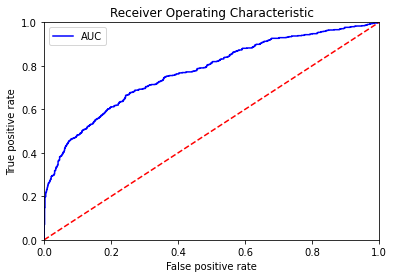

In [81]:
# Evaluate the Bertclassifier
evaluate_roc(probabilities,y_ts)

<font color=red> <b> ! PLease upvote to carry on , if you like it. </font>